<a href="https://colab.research.google.com/github/Tshepang-amir/MSc-Implementation/blob/main/KNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# ============================================================================
# Load Saved DataFrame from Pickle File
# ============================================================================

import pandas as pd

# Path to previously saved pickle file
PICKLE_PATH =  "/content/drive/MyDrive/MSc Research/final_df.pkl"

# Load the DataFrame
df = pd.read_pickle(PICKLE_PATH)

In [ ]:
import os, csv, json, joblib, time
import numpy as np
import pandas as pd


from sklearn.model_selection import (
    train_test_split,
    StratifiedShuffleSplit,
    ParameterGrid,
    KFold
)

from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
    r2_score
)

# =============================================================================
# Subsampling & Model Evaluation
# =============================================================================
def stratified_subsample(data, frac=0.1, n_bins=10, random_state=42):
    if frac >= 1.0:
        return data.copy()
    tmp = data.copy()
    tmp["prem_bin"] = pd.qcut(tmp["PREMIUM"], q=n_bins, labels=False, duplicates="drop")
    splitter = StratifiedShuffleSplit(n_splits=1, test_size=frac, random_state=random_state)
    idx = next(splitter.split(tmp, tmp["prem_bin"]))[1]
    return tmp.iloc[idx].drop(columns=["prem_bin"])

In [ ]:
# ================================================================
# KNN Results: CV RMSE + Test Performance (All Fractions)
# ================================================================
import joblib, numpy as np, pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor

# --- Paths to saved KNN models ---
knn_model_paths = {
    "10%":  "/content/drive/MyDrive/MSc Research/KNN/knn_10.joblib",
    "25%":  "/content/drive/MyDrive/MSc Research/KNN/knn_25.joblib",
    "50%":  "/content/drive/MyDrive/MSc Research/KNN/knn_50.joblib",
    "75%":  "/content/drive/MyDrive/MSc Research/KNN/knn_75.joblib",
    "100%": "/content/drive/MyDrive/MSc Research/KNN/knn_100.joblib",
}

# --- CV RMSE recompute helper ---
def recompute_cv_rmse(X, y, n_neighbors, p, weights, cv=5):
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("knn", KNeighborsRegressor(n_neighbors=n_neighbors, p=p, weights=weights))
    ])
    scores = cross_val_score(pipe, X, y, cv=cv,
                             scoring="neg_root_mean_squared_error", n_jobs=-1)
    return -scores.mean()

# --- Collect results ---
results = []
for frac, path in knn_model_paths.items():
    print(f"\n>>> Evaluating KNN {frac} model from {path}")
    model = joblib.load(path)

    # Extract best params from loaded model
    knn_params = model.get_params()["knn"]
    n_neighbors = knn_params.n_neighbors
    p           = knn_params.p
    weights     = knn_params.weights

    # Recreate stratified subset
    f = float(frac.strip("%")) / 100
    dsub = stratified_subsample(df, frac=f, random_state=42)
    X = dsub.drop(columns=["PREMIUM"])
    y = dsub["PREMIUM"]

    # --- CV RMSE ---
    cv_rmse = recompute_cv_rmse(X, y, n_neighbors, p, weights, cv=5)

    # --- Test performance (20% split) ---
    _, X_test, _, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
    preds = model.predict(X_test)

    r2   = r2_score(y_test, preds)
    mae  = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mape = mean_absolute_percentage_error(y_test, preds) * 100

    results.append({
        "Sample": frac,
        "Best Params": f"n={n_neighbors}, p={p}, w={weights}",
        "CV RMSE (avg)": cv_rmse,
        "Test R²": r2,
        "Test RMSE": rmse,
        "Test MAE": mae,
        "Test MAPE (%)": mape
    })

# --- Build results DataFrame ---
knn_results_df = pd.DataFrame(results)
print("\n=== Final KNN Results Table ===")
print(knn_results_df.to_string(index=False, float_format="%.4f"))


>>> Evaluating KNN 10% model from /content/drive/MyDrive/MSc Research/KNN/knn_10.joblib

>>> Evaluating KNN 25% model from /content/drive/MyDrive/MSc Research/KNN/knn_25.joblib

>>> Evaluating KNN 50% model from /content/drive/MyDrive/MSc Research/KNN/knn_50.joblib

>>> Evaluating KNN 75% model from /content/drive/MyDrive/MSc Research/KNN/knn_75.joblib

>>> Evaluating KNN 100% model from /content/drive/MyDrive/MSc Research/KNN/knn_100.joblib

=== Final KNN Results Table ===
Sample           Best Params  CV RMSE (avg)  Test R²  Test RMSE  Test MAE  Test MAPE (%)
   10% n=19, p=1, w=distance        60.6757   0.5813    60.6074   41.3163        23.1118
   25% n=19, p=1, w=distance        58.3953   0.6005    58.7315   39.7879        22.2091
   50% n=19, p=1, w=distance        56.8921   0.6300    56.5044   38.6080        21.4243
   75% n=19, p=1, w=distance        56.1163   0.6349    56.3381   38.4916        21.3566
  100% n=19, p=1, w=distance        55.6562   0.6411    55.5164   37.9485  

In [ ]:
# ================================================================
# Extended KNN CV Curve Evaluation (save per-k CV RMSE)
# ================================================================
import os, joblib, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor


# --- CV RMSE for curve ---
def knn_rmse_curve(X, y, p=2, weights="distance", k_range=range(3,51,2), cv=5):
    rmses = []
    for k in k_range:
        pipe = Pipeline([
            ("scaler", StandardScaler()),
            ("knn", KNeighborsRegressor(n_neighbors=k, p=p, weights=weights))
        ])
        scores = cross_val_score(pipe, X, y, cv=cv,
                                 scoring="neg_root_mean_squared_error", n_jobs=-1)
        rmses.append((-scores.mean()))
    return list(k_range), rmses

# --- Paths to saved KNN models ---
knn_model_paths = {
    "10%":  "/content/drive/MyDrive/MSc Research/KNN/knn_10.joblib",
    "25%":  "/content/drive/MyDrive/MSc Research/KNN/knn_25.joblib",
    "50%":  "/content/drive/MyDrive/MSc Research/KNN/knn_50.joblib",
    "75%":  "/content/drive/MyDrive/MSc Research/KNN/knn_75.joblib",
    "100%": "/content/drive/MyDrive/MSc Research/KNN/knn_100.joblib",
}


# --- Collect per-k curves ---
all_curves = []
for frac, path in knn_model_paths.items():
    print(f"\n>>> Computing CV RMSE curve for {frac} model")
    model = joblib.load(path)
    knn_params = model.get_params()["knn"]

    f = float(frac.strip("%")) / 100
    dsub = stratified_subsample(df, frac=f, random_state=42)
    X = dsub.drop(columns=["PREMIUM"])
    y = dsub["PREMIUM"]

    ks, rmses = knn_rmse_curve(X, y, p=knn_params.p, weights=knn_params.weights)

    for k, rmse in zip(ks, rmses):
        all_curves.append({
            "Sample": frac,
            "k": k,
            "CV RMSE": rmse,
            "weights": knn_params.weights,
            "p": knn_params.p
        })

# --- Save results ---
curve_df = pd.DataFrame(all_curves)
csv_curve = "/content/drive/MyDrive/MSc Research/KNN/knn_cv_curve.csv"
json_curve = "/content/drive/MyDrive/MSc Research/KNN/knn_cv_curve.json"

curve_df.to_csv(csv_curve, index=False)
curve_df.to_json(json_curve, orient="records", indent=2)

print(f"\nSaved CV RMSE curves to:\n {csv_curve}\n {json_curve}")



>>> Computing CV RMSE curve for 10% model

>>> Computing CV RMSE curve for 25% model

>>> Computing CV RMSE curve for 50% model

>>> Computing CV RMSE curve for 75% model

>>> Computing CV RMSE curve for 100% model

Saved CV RMSE curves to:
 /content/drive/MyDrive/MSc Research/KNN/knn_cv_curve.csv
 /content/drive/MyDrive/MSc Research/KNN/knn_cv_curve.json


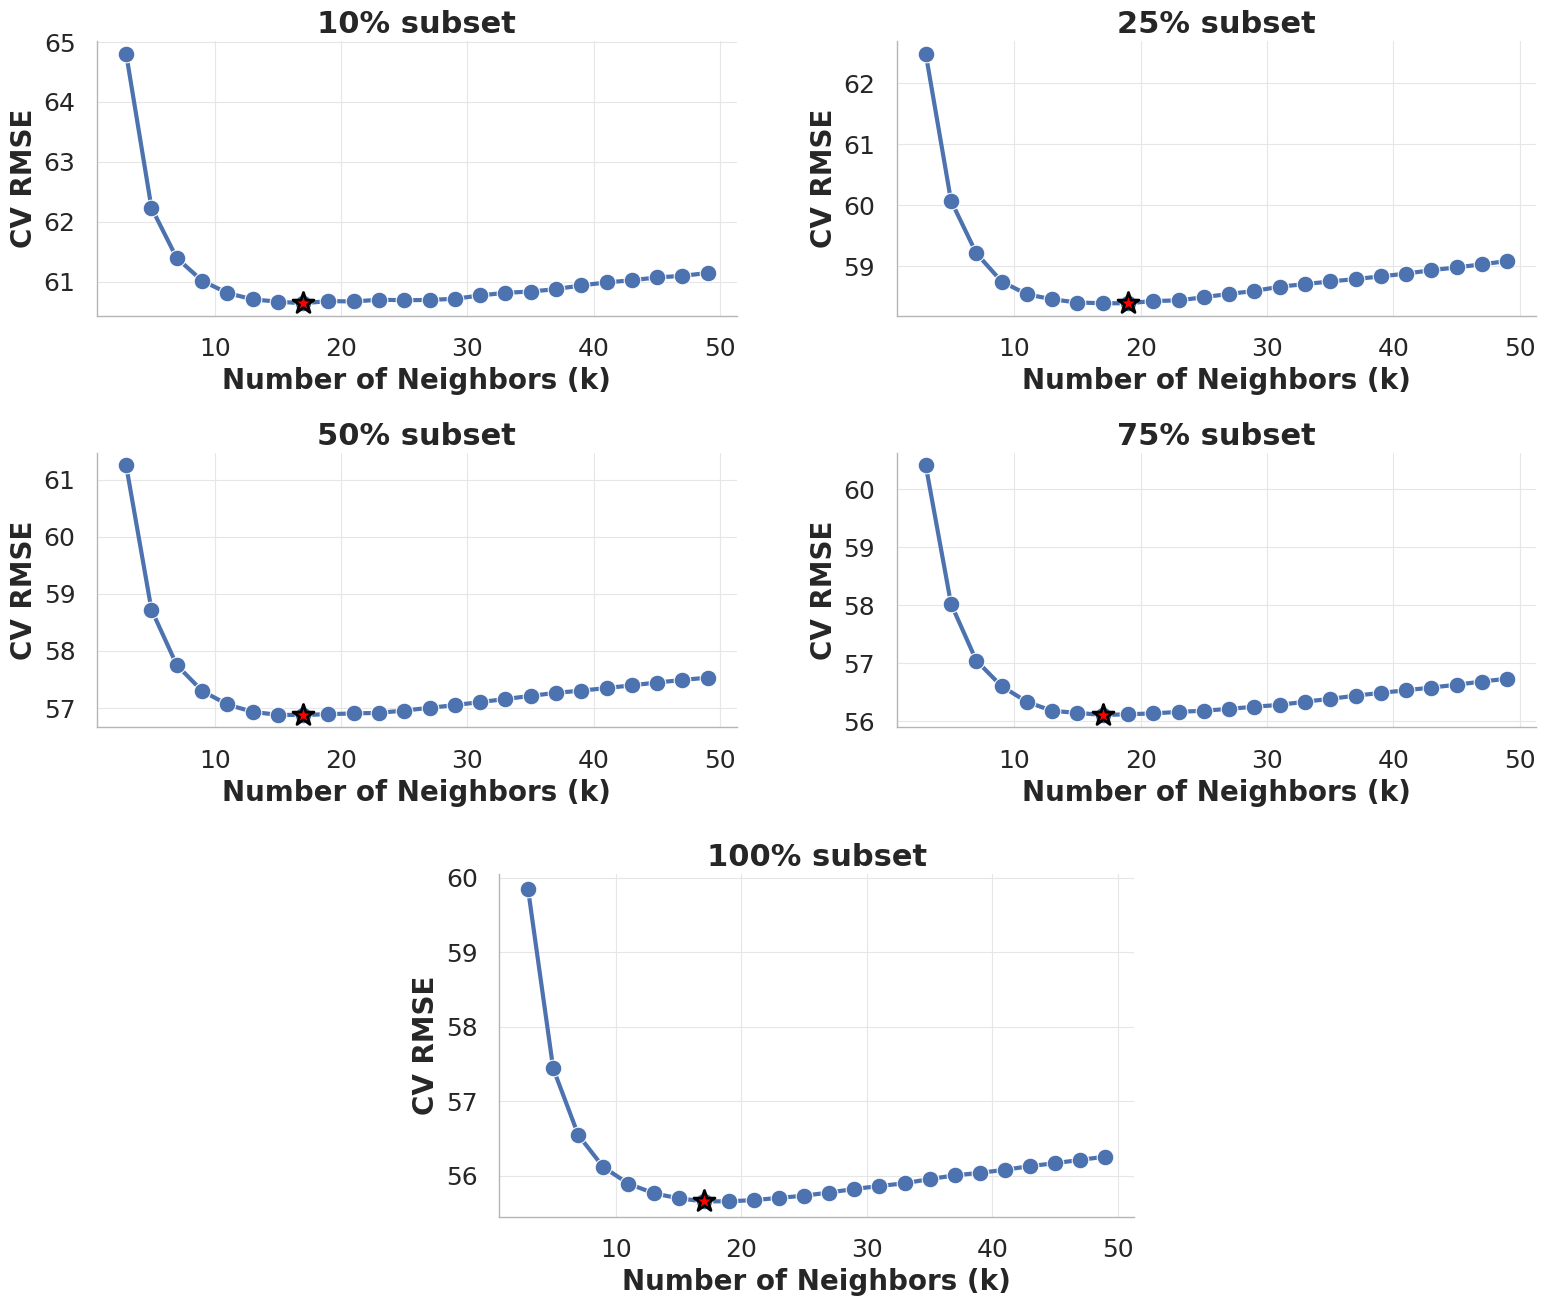

In [ ]:
# ================================================================
# Multi-panel Plot: KNN CV RMSE vs Number of Neighbors (k)
# ================================================================
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Paths ---
csv_curve = "/content/drive/MyDrive/MSc Research/KNN/knn_cv_curve.csv"
curve_df = pd.read_csv(csv_curve)

# --- Style ---
sns.set_theme(style="whitegrid", context="poster")  # bigger than "talk"
plt.rcParams.update({
    "axes.titleweight": "bold",
    "axes.labelweight": "semibold",
    "axes.edgecolor": "#B5B5B5",
    "axes.linewidth": 1.0,
    "grid.color": "#E6E6E6",
    "grid.linewidth": 0.8,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "legend.frameon": False,
    "axes.titlesize": 18,   # subplot titles
    "axes.labelsize": 18,   # axis labels
    "xtick.labelsize": 18,  # tick labels
    "ytick.labelsize": 18,  # tick labels
})

def plot_knn_panel(ax, subset, title):
    dfc = curve_df[curve_df["Sample"] == subset].copy()
    if dfc.empty:
        ax.set_visible(False)
        return

    # Aggregate mean CV RMSE per k
    agg = (dfc.groupby("k", as_index=False)["CV RMSE"]
              .mean()
              .sort_values("k"))

    # Lineplot
    sns.lineplot(data=agg, x="k", y="CV RMSE", marker="o", lw=3.0, ax=ax)
    ax.set_title(title, fontsize=22, weight="bold")
    ax.set_xlabel("Number of Neighbors (k)", fontsize=20, weight="semibold")
    ax.set_ylabel("CV RMSE", fontsize=20, weight="semibold")

    # Highlight best point with a star
    i_min = agg["CV RMSE"].idxmin()
    xm, ym = int(agg.loc[i_min, "k"]), float(agg.loc[i_min, "CV RMSE"])
    ax.scatter([xm], [ym], s=250, c="red", marker="*", edgecolors="black", zorder=5)

# --- GridSpec layout ---
fig = plt.figure(figsize=(16, 14))
outer = fig.add_gridspec(2, 1, height_ratios=[2, 1])

# top 2×2
top = outer[0].subgridspec(2, 2, wspace=0.25, hspace=0.5)
ax_10  = fig.add_subplot(top[0, 0])
ax_25  = fig.add_subplot(top[0, 1])
ax_50  = fig.add_subplot(top[1, 0])
ax_75  = fig.add_subplot(top[1, 1])

# bottom 1×3, use only middle cell
bottom = outer[1].subgridspec(1, 3, width_ratios=[1, 2, 1])
ax_100 = fig.add_subplot(bottom[0, 1])

# --- Plot each subset ---
plot_knn_panel(ax_10,  "10%",  "10% subset")
plot_knn_panel(ax_25,  "25%",  "25% subset")
plot_knn_panel(ax_50,  "50%",  "50% subset")
plot_knn_panel(ax_75,  "75%",  "75% subset")
plot_knn_panel(ax_100, "100%", "100% subset")

# --- Layout ---
plt.tight_layout(rect=[0, 0, 1, 0.97])

# --- Save high-quality PDF ---
out_pdf = "/content/drive/MyDrive/MSc Research/KNN/knn_cv_curve_panels.pdf"
plt.savefig(out_pdf, format="pdf", dpi=600, bbox_inches="tight")

plt.show()


In [ ]:
# ================================================================
# KNN Model Evaluation & Save Results
# ================================================================
import os, joblib, json
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error,
    mean_absolute_percentage_error, r2_score
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor


# --- CV RMSE recompute helper ---
def recompute_cv_rmse(X, y, n_neighbors, p, weights, cv=5):
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("knn", KNeighborsRegressor(n_neighbors=n_neighbors, p=p, weights=weights))
    ])
    scores = cross_val_score(pipe, X, y, cv=cv,
                             scoring="neg_root_mean_squared_error", n_jobs=-1)
    return -scores.mean()

# --- Paths to saved KNN models ---
knn_model_paths = {
    "10%":  "/content/drive/MyDrive/MSc Research/KNN/knn_10.joblib",
    "25%":  "/content/drive/MyDrive/MSc Research/KNN/knn_25.joblib",
    "50%":  "/content/drive/MyDrive/MSc Research/KNN/knn_50.joblib",
    "75%":  "/content/drive/MyDrive/MSc Research/KNN/knn_75.joblib",
    "100%": "/content/drive/MyDrive/MSc Research/KNN/knn_100.joblib",
}

# --- Collect results ---
results = []
for frac, path in knn_model_paths.items():
    print(f"\n>>> Evaluating KNN {frac} model from {path}")
    model = joblib.load(path)

    # Extract hyperparameters from pipeline
    knn_params = model.get_params()["knn"]
    n_neighbors = knn_params.n_neighbors
    p           = knn_params.p
    weights     = knn_params.weights

    # Recreate dataset subset
    f = float(frac.strip("%")) / 100
    dsub = stratified_subsample(df, frac=f, random_state=42)
    X = dsub.drop(columns=["PREMIUM"])
    y = dsub["PREMIUM"]

    # CV RMSE
    cv_rmse = recompute_cv_rmse(X, y, n_neighbors, p, weights, cv=5)

    # Test set (20%)
    _, X_test, _, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
    preds = model.predict(X_test)

    r2   = r2_score(y_test, preds)
    mae  = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mape = mean_absolute_percentage_error(y_test, preds) * 100

    results.append({
        "Sample": frac,
        "Best Params": f"n={n_neighbors}, p={p}, w={weights}",
        "CV RMSE (avg)": cv_rmse,
        "Test RMSE": rmse,
        "Test MAE": mae,
        "Test R²": r2,
        "Test MAPE (%)": mape
    })

# --- Save results ---
results_df = pd.DataFrame(results)
csv_path   = "/content/drive/MyDrive/MSc Research/KNN/knn_eval_results.csv"
json_path  = "/content/drive/MyDrive/MSc Research/KNN/knn_eval_results.json"

results_df.to_csv(csv_path, index=False)
results_df.to_json(json_path, orient="records", indent=2)

print("\n=== Final KNN Results Table ===")
print(results_df.to_string(index=False, float_format="%.4f"))
print(f"\nResults saved to:\n {csv_path}\n {json_path}")



>>> Evaluating KNN 10% model from /content/drive/MyDrive/MSc Research/KNN/knn_10.joblib

>>> Evaluating KNN 25% model from /content/drive/MyDrive/MSc Research/KNN/knn_25.joblib

>>> Evaluating KNN 50% model from /content/drive/MyDrive/MSc Research/KNN/knn_50.joblib

>>> Evaluating KNN 75% model from /content/drive/MyDrive/MSc Research/KNN/knn_75.joblib

>>> Evaluating KNN 100% model from /content/drive/MyDrive/MSc Research/KNN/knn_100.joblib

=== Final KNN Results Table ===
Sample           Best Params  CV RMSE (avg)  Test RMSE  Test MAE  Test R²  Test MAPE (%)
   10% n=19, p=1, w=distance        60.6757    60.6059   41.3135   0.5813        23.1102
   25% n=19, p=1, w=distance        58.3953    58.7315   39.7879   0.6005        22.2091
   50% n=19, p=1, w=distance        56.8921    56.5044   38.6080   0.6300        21.4243
   75% n=19, p=1, w=distance        56.1163    56.3381   38.4916   0.6349        21.3566
  100% n=19, p=1, w=distance        55.6562    55.5164   37.9485   0.6411  